In [1]:
# Import Packages

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
pd.set_option('display.max_columns', 200)

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
from imblearn.under_sampling import RandomUnderSampler
from sklearn.pipeline import make_pipeline








from scipy.stats import uniform, randint
import time
import joblib
import os


import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.filterwarnings(action="ignore", module="scipy", message="^internal gelsd")

In [2]:
df = pd.read_csv('../data/cleaned_sales_data.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9800 entries, 0 to 9799
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Row ID         9800 non-null   int64  
 1   Order ID       9800 non-null   object 
 2   Order Date     9800 non-null   object 
 3   Ship Date      9800 non-null   object 
 4   Ship Mode      9800 non-null   object 
 5   Customer ID    9800 non-null   object 
 6   Customer Name  9800 non-null   object 
 7   Segment        9800 non-null   object 
 8   City           9800 non-null   object 
 9   State          9800 non-null   object 
 10  Zip Code       9800 non-null   int64  
 11  Region         9800 non-null   object 
 12  Product ID     9800 non-null   object 
 13  Category       9800 non-null   object 
 14  Sub-Category   9800 non-null   object 
 15  Product Name   9800 non-null   object 
 16  Sales Revenue  9800 non-null   float64
dtypes: float64(1), int64(2), object(14)
memory usage: 1.

## First we'll drop the colmns that, although useful in our prior EDA, are identifiers and do not have any predictive value in predicting furture sales:
1) Row ID
2) Order ID
3) Customer ID
4) Customer Name
5) Product Name: already identified with Product ID which will be Count Encoded

In [4]:
df.drop(columns =['Row ID', 'Order ID', 'Customer ID', 'Customer Name', 'Product Name'], inplace=True)

In [5]:
# Convert Order Date and Ship Date to Datetime format
df['Order Date'] = pd.to_datetime(df['Order Date'])
df['Ship Date'] = pd.to_datetime(df['Ship Date'])

# Extracting features from 'Order Date'
df['Order Year'] = df['Order Date'].dt.year.astype('int64')
df['Order Month'] = df['Order Date'].dt.month.astype('int64')
df['Order Day'] = df['Order Date'].dt.day.astype('int64')
df['Order Day of Week'] = df['Order Date'].dt.dayofweek.astype('int64')
df['Order Week of Year'] = df['Order Date'].dt.isocalendar().week.astype('int64')

# With our dates extracted as individual features, we can safely drop the the original Order Date column which is in Datetime format.
# We will also drop the Ship Date column to prevent any potential data leakage as Ship Date always trails Order Date by a couple days.
df.drop(columns =['Order Date', 'Ship Date'], inplace=True)

In [6]:
# Fill null values in Zip Code with 99999
df['Zip Code'] = df['Zip Code'].fillna(99999)

# Convert zip codes to strings and remove the .0 suffix
df['Zip Code'] = df['Zip Code'].astype(str).str.replace('.0', '')

# Add leading zeros to zip codes that have only 4 digits
df['Zip Code'] = df['Zip Code'].apply(lambda x: x.zfill(5))

In [7]:
df.head()

,Ship Mode,Segment,City,State,Zip Code,Region,Product ID,Category,Sub-Category,Sales Revenue,Order Year,Order Month,Order Day,Order Day of Week,Order Week of Year
0,Second Class,Consumer,Henderson,Kentucky,42420,South,FUR-BO-10001798,Furniture,Bookcases,261.96,2017,11,8,2,45
1,Second Class,Consumer,Henderson,Kentucky,42420,South,FUR-CH-10000454,Furniture,Chairs,731.94,2017,11,8,2,45
2,Second Class,Corporate,Los Angeles,California,90036,West,OFF-LA-10000240,Office Supplies,Labels,14.62,2017,6,12,0,24
3,Standard Class,Consumer,Fort Lauderdale,Florida,33311,South,FUR-TA-10000577,Furniture,Tables,957.58,2016,10,11,1,41
4,Standard Class,Consumer,Fort Lauderdale,Florida,33311,South,OFF-ST-10000760,Office Supplies,Storage,22.37,2016,10,11,1,41


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9800 entries, 0 to 9799
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Ship Mode           9800 non-null   object 
 1   Segment             9800 non-null   object 
 2   City                9800 non-null   object 
 3   State               9800 non-null   object 
 4   Zip Code            9800 non-null   object 
 5   Region              9800 non-null   object 
 6   Product ID          9800 non-null   object 
 7   Category            9800 non-null   object 
 8   Sub-Category        9800 non-null   object 
 9   Sales Revenue       9800 non-null   float64
 10  Order Year          9800 non-null   int64  
 11  Order Month         9800 non-null   int64  
 12  Order Day           9800 non-null   int64  
 13  Order Day of Week   9800 non-null   int64  
 14  Order Week of Year  9800 non-null   int64  
dtypes: float64(1), int64(5), object(9)
memory usage: 1.1+ M

## Now that our data is back in the correct format, we can begin encoding our categorical features. We'll be One-Hot encoding categorical features with less than 50 unique values and Count encoding features with 50 or more unique values.

In [9]:
# Create a DataFrame with column names, number of unique values, and data types
unique_counts_df = pd.DataFrame({
    'Column Name': df.columns,
    'Number of Unique Values': [df[col].nunique() for col in df.columns],
    'Data Type': [df[col].dtype for col in df.columns]
})

unique_counts_df

,Column Name,Number of Unique Values,Data Type
0,Ship Mode,4,object
1,Segment,3,object
2,City,529,object
3,State,49,object
4,Zip Code,627,object
5,Region,4,object
6,Product ID,1861,object
7,Category,3,object
8,Sub-Category,17,object
9,Sales Revenue,5395,float64


In [10]:
# Count Encoding
# Calculate the frequency of each value in the 'City', 'Zip Code', & 'Product ID' columns then map to the original column
df_encoded = df
city_frequency = df_encoded['City'].value_counts()
df_encoded['City'] = df_encoded['City'].map(city_frequency)

zip_code_frequency = df_encoded['Zip Code'].value_counts()
df_encoded['Zip Code'] = df_encoded['Zip Code'].map(zip_code_frequency)

product_id_frequency = df['Product ID'].value_counts()
df_encoded['Product ID'] = df_encoded['Product ID'].map(product_id_frequency)

In [11]:
# Apply one-hot encoding
df_encoded = pd.get_dummies(df_encoded, drop_first=True)

In [12]:
df_encoded.replace({False: 0, True: 1}, inplace=True)
df_encoded

,City,Zip Code,Product ID,Sales Revenue,Order Year,Order Month,Order Day,Order Day of Week,Order Week of Year,Ship Mode_Same Day,Ship Mode_Second Class,Ship Mode_Standard Class,Segment_Corporate,Segment_Home Office,State_Arizona,State_Arkansas,State_California,State_Colorado,State_Connecticut,State_Delaware,State_District of Columbia,State_Florida,State_Georgia,State_Idaho,State_Illinois,State_Indiana,State_Iowa,State_Kansas,State_Kentucky,State_Louisiana,State_Maine,State_Maryland,State_Massachusetts,State_Michigan,State_Minnesota,State_Mississippi,State_Missouri,State_Montana,State_Nebraska,State_Nevada,State_New Hampshire,State_New Jersey,State_New Mexico,State_New York,State_North Carolina,State_North Dakota,State_Ohio,State_Oklahoma,State_Oregon,State_Pennsylvania,State_Rhode Island,State_South Carolina,State_South Dakota,State_Tennessee,State_Texas,State_Utah,State_Vermont,State_Virginia,State_Washington,State_West Virginia,State_Wisconsin,State_Wyoming,Region_East,Region_South,Region_West,Category_Office Supplies,Category_Technology,Sub-Category_Appliances,Sub-Category_Art,Sub-Category_Binders,Sub-Category_Bookcases,Sub-Category_Chairs,Sub-Category_Copiers,Sub-Category_Envelopes,Sub-Category_Fasteners,Sub-Category_Furnishings,Sub-Category_Labels,Sub-Category_Machines,Sub-Category_Paper,Sub-Category_Phones,Sub-Category_Storage,Sub-Category_Supplies,Sub-Category_Tables
0,51,48,4,261.96,2017,11,8,2,45,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1,51,48,12,731.94,2017,11,8,2,45,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,728,122,7,14.62,2017,6,12,0,24,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
3,13,13,8,957.58,2016,10,11,1,41,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,13,13,5,22.37,2016,10,11,1,41,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9795,308,108,9,3.80,2017,5,21,6,20,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
9796,31,31,6,10.37,2016,1,12,1,2,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9797,31,31,9,235.19,2016,1,12,1,2,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
9798,31,31,2,26.38,2016,1,12,1,2,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


In [13]:
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9800 entries, 0 to 9799
Data columns (total 83 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   City                        9800 non-null   int64  
 1   Zip Code                    9800 non-null   int64  
 2   Product ID                  9800 non-null   int64  
 3   Sales Revenue               9800 non-null   float64
 4   Order Year                  9800 non-null   int64  
 5   Order Month                 9800 non-null   int64  
 6   Order Day                   9800 non-null   int64  
 7   Order Day of Week           9800 non-null   int64  
 8   Order Week of Year          9800 non-null   int64  
 9   Ship Mode_Same Day          9800 non-null   int64  
 10  Ship Mode_Second Class      9800 non-null   int64  
 11  Ship Mode_Standard Class    9800 non-null   int64  
 12  Segment_Corporate           9800 non-null   int64  
 13  Segment_Home Office         9800 

In [14]:
#Save Encoded DataFrame as CSV
df_encoded.to_csv('../data/Cleaned_And_Encoded_Sales_Data_For_Modeling.csv', index=False)

## Now that our data is encoded, we'll want to split our data into our features and target variable. Our target variable is of course, Sales Revenue.

In [15]:
#Split data into Features and target variable 'Sales Revenue'
X = df_encoded.drop('Sales Revenue', axis=1)
y = df_encoded['Sales Revenue']

In [16]:
#Split data into Train & Test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=7)

## As most of our features are on different scales, we will scale our data so as not to bias our model toward any given feature unjustly.

## We will also want to run PCA (as we currently have 82 features) and determine the best trade off of dimensionality reduction and explaining the most variance possible.

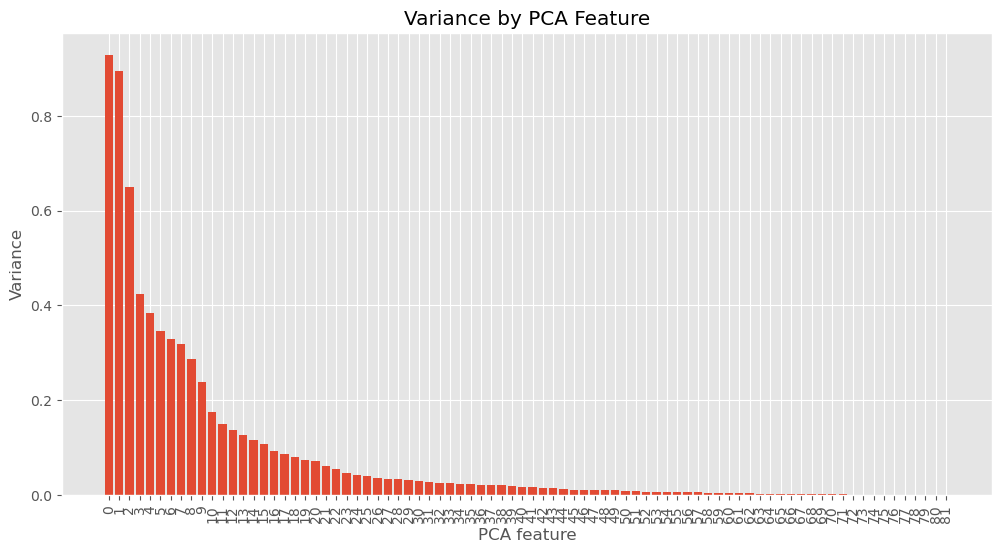

In [20]:
# Create scaler: scaler
scaler = RobustScaler()

# Create a PCA instance: pca
pca = PCA(random_state=7)

# Create pipeline: pipeline
pipeline = make_pipeline(scaler, pca)

# Fit the pipeline to the training data
pipeline.fit(X_train)

# Plot the explained variances
features = range(pca.n_components_)
plt.figure(figsize=(12,6))
plt.bar(features, pca.explained_variance_)
plt.xlabel('PCA feature')
plt.ylabel('Variance')
plt.title('Variance by PCA Feature')
plt.xticks(features, rotation=90)
plt.show()

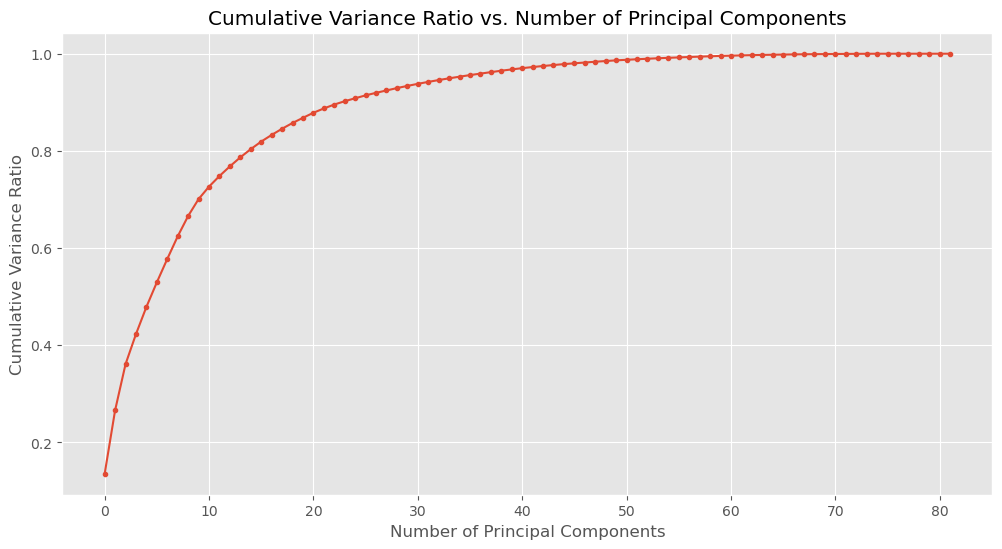

In [18]:
cumulative_variance_ratio = np.cumsum(pca.explained_variance_ratio_)

# Plot the cumulative variance ratio
plt.figure(figsize=(12,6))
plt.plot(cumulative_variance_ratio, marker='.', linestyle='-')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Variance Ratio')
plt.title('Cumulative Variance Ratio vs. Number of Principal Components')
plt.grid(True)
plt.show();